# About this notebook
- PyTorch efficientnet_b0 with W&B starter code
- Pytorch W&B Usage Examples from https://docs.wandb.ai/guides/integrations/pytorch

If this notebook is helpful, feel free to upvote :)

In [1]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [3]:
timm.list_models('*eff*')

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientformerv2_l',
 'efficientformerv2_s0',
 'efficientformerv2_s1',
 'efficientformerv2_s2',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficie

In [4]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=10
    num_workers=4
    size=224
    model_name='tf_efficientnet_b4_ns'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=40
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='KIc'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    grad_cam=True
    

In [5]:
df = pd.read_csv('~/KIc/vgg16_KIC/inout_data.csv', header=None, names=['Id', 'KIc'])
df['file_path'] = ['./KIc/imagedata/1' + str(i).zfill(5) + '.jpg' for i in df['Id']]
train = df

# train, test = train_test_split(df, test_size=0.1, random_state=CFG.seed)
# train.reset_index(inplace=True, drop=True)
# test.reset_index(inplace=True, drop=True)

display(train.head())
# display(test.head())

if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=100, random_state=CFG.seed).reset_index(drop=True)

,Id,KIc,file_path
0,95,3.55,./KIc/imagedata/100095.jpg
1,96,3.74,./KIc/imagedata/100096.jpg
2,97,3.68,./KIc/imagedata/100097.jpg
3,98,3.72,./KIc/imagedata/100098.jpg
4,99,3.61,./KIc/imagedata/100099.jpg


# Quick EDA

<Axes: >

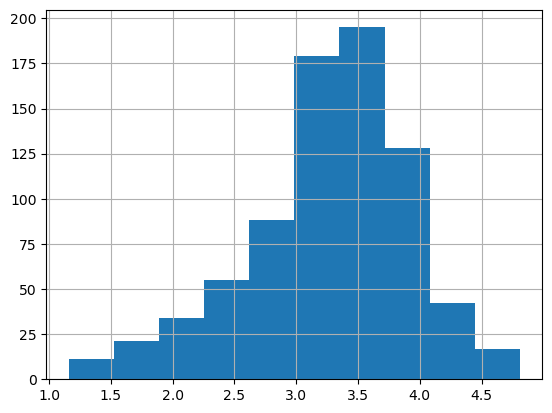

In [6]:
train['KIc'].hist()

In [7]:
# plt.figure(figsize=(20, 20))
# row, col = 5, 5
# for i in range(row * col):
#     plt.subplot(col, row, i+1)
#     image = cv2.imread(train.loc[i, 'file_path'])
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     target = train.loc[i, 'KIc']
#     plt.imshow(image)
#     plt.title(f"target: {target}")
# plt.show()

# Directory settings

In [8]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './KIc/cnn'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

# Library

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [10]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)

Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())

fold  bins
0     0        2
      1        5
      2        6
      3       11
      4       17
      5       36
      6       39
      7       26
      8        9
      9        3
1     0        2
      1        4
      2        7
      3       11
      4       17
      5       36
      6       39
      7       26
      8        9
      9        3
2     0        2
      1        4
      2        7
      3       11
      4       18
      5       36
      6       39
      7       26
      8        8
      9        3
3     0        2
      1        4
      2        7
      3       11
      4       18
      5       36
      6       39
      7       25
      8        8
      9        4
4     0        3
      1        4
      2        7
      3       11
      4       18
      5       35
      6       39
      7       25
      8        8
      9        4
dtype: int64

In [11]:
train.to_pickle(OUTPUT_DIR+'train.pkl')

# Dataset

In [12]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

    
class GradCAMDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_ids = df['Id'].values
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = get_transforms(data='valid')
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        vis_image = cv2.resize(image, (CFG.size, CFG.size)).copy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image_id, image, vis_image, label

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# MODEL

In [14]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=True):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# Loss

In [15]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Helper functions

In [16]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))

    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    losses = AverageMeter()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [17]:
def get_grad_cam(model, device, x_tensor, img, label, plot=False):
    result = {"vis": None, "img": None, "pred": None, "label": None}
    print("x_tensor", x_tensor.shape)
    print("x_tensor", x_tensor.unsqueeze(0).shape)
    with torch.no_grad():
        pred = model(x_tensor.unsqueeze(0).to(device))
#         pred = model(x_tensor.to(device))
    pred = np.concatenate(pred.to('cpu').numpy())[0]
    target_layer = [model.model.blocks[-1].norm1]
    cam = GradCAM(model=model, target_layers=target_layer, use_cuda=torch.cuda.is_available())
    from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget
#     targets = [RawScoresOutputTarget()]
    targets = None
    output = cam(input_tensor=x_tensor.unsqueeze(0).to(device), targets=targets)
#     output = cam(input_tensor=x_tensor.to(device))
    try:
        vis = show_cam_on_image(img / 255., output[0])
    except:
        return result
    if plot:
        fig, axes = plt.subplots(figsize=(8, 8), ncols=2)
        axes[0].imshow(vis)
        axes[0].set_title(f"pred={pred:.4f}")
        axes[1].imshow(img)
        axes[1].set_title(f"target={label}")
        plt.show()
    result = {"vis": vis, "img": img, "pred": pred, "label": label}
    torch.cuda.empty_cache()
    return result

# Train loop

In [18]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = RMSELoss()

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
       
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [19]:
# !pip install torchinfo
# from torchinfo import summary
# model = CustomModel(CFG, pretrained=True)
# summary(model)

In [20]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+f'{CFG.model_name}oof_df.csv', index=False)

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/19] Elapsed 0m 2s (remain 0m 38s) Loss: 3.4967(3.4967) Grad: 3.7027  LR: 0.000100  
Epoch: [1][10/19] Elapsed 0m 3s (remain 0m 2s) Loss: 2.7324(3.1661) Grad: 2.9129  LR: 0.000100  
Epoch: [1][18/19] Elapsed 0m 4s (remain 0m 0s) Loss: 2.0551(2.8807) Grad: 3.7762  LR: 0.000100  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 2.2144(2.2144) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 2.2027(2.1218) 


Epoch 1 - avg_train_loss: 2.8807  avg_val_loss: 2.1218  time: 5s
Epoch 1 - Score: 2.1244
Epoch 1 - Save Best Score: 2.1244 Model


Epoch: [2][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 2.2073(2.2073) Grad: 3.8923  LR: 0.000057  
Epoch: [2][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 1.2114(1.6511) Grad: 4.9458  LR: 0.000057  
Epoch: [2][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5851(1.2915) Grad: 6.1929  LR: 0.000057  


Epoch 2 - avg_train_loss: 1.2915  avg_val_loss: 0.8348  time: 4s
Epoch 2 - Score: 0.8374
Epoch 2 - Save Best Score: 0.8374 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.8540(0.8540) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.6895(0.8348) 
Epoch: [3][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4477(0.4477) Grad: 4.4183  LR: 0.000009  
Epoch: [3][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.5067(0.5232) Grad: 4.5539  LR: 0.000009  
Epoch: [3][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3750(0.4789) Grad: 4.3941  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.5349(0.5349) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.3253(0.5252) 


Epoch 3 - avg_train_loss: 0.4789  avg_val_loss: 0.5252  time: 4s
Epoch 3 - Score: 0.5336
Epoch 3 - Save Best Score: 0.5336 Model


Epoch: [4][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4875(0.4875) Grad: 5.2954  LR: 0.000001  
Epoch: [4][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.3105(0.4092) Grad: 4.4889  LR: 0.000001  
Epoch: [4][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3230(0.4224) Grad: 3.7989  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.5257(0.5257) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2897(0.4918) 


Epoch 4 - avg_train_loss: 0.4224  avg_val_loss: 0.4918  time: 4s
Epoch 4 - Score: 0.5002
Epoch 4 - Save Best Score: 0.5002 Model


Epoch: [5][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4366(0.4366) Grad: 4.8454  LR: 0.000050  
Epoch: [5][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.4152(0.3982) Grad: 4.3351  LR: 0.000050  
Epoch: [5][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4214(0.3995) Grad: 3.9157  LR: 0.000050  


Epoch 5 - avg_train_loss: 0.3995  avg_val_loss: 0.5003  time: 4s
Epoch 5 - Score: 0.5042


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.5064(0.5064) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.3683(0.5003) 
Epoch: [6][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4111(0.4111) Grad: 4.3777  LR: 0.000224  
Epoch: [6][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.3087(0.3642) Grad: 3.8605  LR: 0.000224  
Epoch: [6][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5117(0.3728) Grad: 3.9176  LR: 0.000224  


Epoch 6 - avg_train_loss: 0.3728  avg_val_loss: 0.4861  time: 4s
Epoch 6 - Score: 0.4938
Epoch 6 - Save Best Score: 0.4938 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.5406(0.5406) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2964(0.4861) 
Epoch: [7][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.3476(0.3476) Grad: 4.2155  LR: 0.000133  
Epoch: [7][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2907(0.3031) Grad: 3.1579  LR: 0.000133  
Epoch: [7][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3158(0.3150) Grad: 4.0731  LR: 0.000133  


Epoch 7 - avg_train_loss: 0.3150  avg_val_loss: 0.4968  time: 4s
Epoch 7 - Score: 0.4980


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4995(0.4995) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4237(0.4968) 
Epoch: [8][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2913(0.2913) Grad: 3.5964  LR: 0.000057  
Epoch: [8][10/19] Elapsed 0m 2s (remain 0m 1s) Loss: 0.2954(0.3010) Grad: 3.8196  LR: 0.000057  
Epoch: [8][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2828(0.3024) Grad: 3.4271  LR: 0.000057  


Epoch 8 - avg_train_loss: 0.3024  avg_val_loss: 0.4216  time: 4s
Epoch 8 - Score: 0.4284
Epoch 8 - Save Best Score: 0.4284 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4643(0.4643) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2537(0.4216) 
Epoch: [9][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2556(0.2556) Grad: 3.8118  LR: 0.000009  
Epoch: [9][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2888(0.2609) Grad: 3.5356  LR: 0.000009  
Epoch: [9][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1889(0.2646) Grad: 3.1819  LR: 0.000009  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4807(0.4807) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2312(0.4541) 


Epoch 9 - avg_train_loss: 0.2646  avg_val_loss: 0.4541  time: 4s
Epoch 9 - Score: 0.4654


Epoch: [10][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1758(0.1758) Grad: 3.0614  LR: 0.000001  
Epoch: [10][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2642(0.2386) Grad: 4.6944  LR: 0.000001  
Epoch: [10][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2860(0.2439) Grad: 4.6238  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4867(0.4867) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2319(0.4318) 


Epoch 10 - avg_train_loss: 0.2439  avg_val_loss: 0.4318  time: 4s
Epoch 10 - Score: 0.4413


Epoch: [11][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2412(0.2412) Grad: 4.0071  LR: 0.000050  
Epoch: [11][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2204(0.2366) Grad: 5.0108  LR: 0.000050  
Epoch: [11][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2376(0.2391) Grad: 4.1605  LR: 0.000050  


Epoch 11 - avg_train_loss: 0.2391  avg_val_loss: 0.4293  time: 4s
Epoch 11 - Score: 0.4384


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4695(0.4695) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2325(0.4293) 
Epoch: [12][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2372(0.2372) Grad: 3.1912  LR: 0.000224  
Epoch: [12][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.4420(0.2711) Grad: 6.0628  LR: 0.000224  
Epoch: [12][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2305(0.2708) Grad: 4.1081  LR: 0.000224  


Epoch 12 - avg_train_loss: 0.2708  avg_val_loss: 0.4503  time: 4s
Epoch 12 - Score: 0.4591


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4803(0.4803) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2531(0.4503) 
Epoch: [13][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2217(0.2217) Grad: 2.9936  LR: 0.000133  
Epoch: [13][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.3136(0.2577) Grad: 4.4106  LR: 0.000133  
Epoch: [13][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2164(0.2529) Grad: 3.8673  LR: 0.000133  


Epoch 13 - avg_train_loss: 0.2529  avg_val_loss: 0.4519  time: 4s
Epoch 13 - Score: 0.4617


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.5281(0.5281) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2558(0.4519) 
Epoch: [14][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2622(0.2622) Grad: 4.2054  LR: 0.000057  
Epoch: [14][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2225(0.2442) Grad: 4.4120  LR: 0.000057  
Epoch: [14][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1814(0.2334) Grad: 3.6250  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.5117(0.5117) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2758(0.4458) 


Epoch 14 - avg_train_loss: 0.2334  avg_val_loss: 0.4458  time: 4s
Epoch 14 - Score: 0.4533


Epoch: [15][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2434(0.2434) Grad: 3.1824  LR: 0.000009  
Epoch: [15][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1557(0.1915) Grad: 3.0479  LR: 0.000009  
Epoch: [15][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2473(0.2007) Grad: 4.3947  LR: 0.000009  


Epoch 15 - avg_train_loss: 0.2007  avg_val_loss: 0.4107  time: 4s
Epoch 15 - Score: 0.4194
Epoch 15 - Save Best Score: 0.4194 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4401(0.4401) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2224(0.4107) 
Epoch: [16][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1704(0.1704) Grad: 3.3410  LR: 0.000001  
Epoch: [16][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2705(0.2036) Grad: 5.4185  LR: 0.000001  
Epoch: [16][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3203(0.2128) Grad: 5.8615  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4517(0.4517) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1880(0.4123) 


Epoch 16 - avg_train_loss: 0.2128  avg_val_loss: 0.4123  time: 4s
Epoch 16 - Score: 0.4245


Epoch: [17][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1829(0.1829) Grad: 2.8606  LR: 0.000050  
Epoch: [17][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1599(0.2130) Grad: 4.5715  LR: 0.000050  
Epoch: [17][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1516(0.2085) Grad: 3.1952  LR: 0.000050  


Epoch 17 - avg_train_loss: 0.2085  avg_val_loss: 0.4151  time: 4s
Epoch 17 - Score: 0.4236


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4742(0.4742) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2331(0.4151) 
Epoch: [18][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2759(0.2759) Grad: 5.0049  LR: 0.000224  
Epoch: [18][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1934(0.2084) Grad: 4.0320  LR: 0.000224  
Epoch: [18][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.3273(0.2093) Grad: 5.5178  LR: 0.000224  


Epoch 18 - avg_train_loss: 0.2093  avg_val_loss: 0.4126  time: 4s
Epoch 18 - Score: 0.4225


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4618(0.4618) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2107(0.4126) 
Epoch: [19][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1974(0.1974) Grad: 3.8229  LR: 0.000133  
Epoch: [19][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2358(0.2314) Grad: 5.2894  LR: 0.000133  
Epoch: [19][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2863(0.2151) Grad: 5.6364  LR: 0.000133  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4691(0.4691) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2178(0.4228) 


Epoch 19 - avg_train_loss: 0.2151  avg_val_loss: 0.4228  time: 4s
Epoch 19 - Score: 0.4328


Epoch: [20][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.3060(0.3060) Grad: 5.5987  LR: 0.000057  
Epoch: [20][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1937(0.2061) Grad: 3.8345  LR: 0.000057  
Epoch: [20][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1674(0.2047) Grad: 2.7696  LR: 0.000057  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.5037(0.5037) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2838(0.4478) 


Epoch 20 - avg_train_loss: 0.2047  avg_val_loss: 0.4478  time: 4s
Epoch 20 - Score: 0.4543


Epoch: [21][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2746(0.2746) Grad: 5.5336  LR: 0.000009  
Epoch: [21][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1590(0.1736) Grad: 2.9849  LR: 0.000009  
Epoch: [21][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1332(0.1786) Grad: 3.5997  LR: 0.000009  


Epoch 21 - avg_train_loss: 0.1786  avg_val_loss: 0.4097  time: 4s
Epoch 21 - Score: 0.4171
Epoch 21 - Save Best Score: 0.4171 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4727(0.4727) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2466(0.4097) 
Epoch: [22][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1929(0.1929) Grad: 3.7267  LR: 0.000001  
Epoch: [22][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1828(0.1952) Grad: 3.3829  LR: 0.000001  
Epoch: [22][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2282(0.1937) Grad: 4.1602  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4502(0.4502) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2670(0.4114) 


Epoch 22 - avg_train_loss: 0.1937  avg_val_loss: 0.4114  time: 4s
Epoch 22 - Score: 0.4166
Epoch 22 - Save Best Score: 0.4166 Model


Epoch: [23][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2352(0.2352) Grad: 4.5511  LR: 0.000050  
Epoch: [23][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1145(0.1699) Grad: 3.1869  LR: 0.000050  
Epoch: [23][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1741(0.1749) Grad: 3.5728  LR: 0.000050  


Epoch 23 - avg_train_loss: 0.1749  avg_val_loss: 0.3988  time: 4s
Epoch 23 - Score: 0.4095
Epoch 23 - Save Best Score: 0.4095 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4534(0.4534) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1941(0.3988) 
Epoch: [24][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2014(0.2014) Grad: 5.2178  LR: 0.000224  
Epoch: [24][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2202(0.1966) Grad: 4.7817  LR: 0.000224  
Epoch: [24][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2192(0.1960) Grad: 3.6249  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4593(0.4593) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2097(0.4234) 


Epoch 24 - avg_train_loss: 0.1960  avg_val_loss: 0.4234  time: 4s
Epoch 24 - Score: 0.4343


Epoch: [25][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1727(0.1727) Grad: 4.7028  LR: 0.000133  
Epoch: [25][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1810(0.1781) Grad: 2.4004  LR: 0.000133  
Epoch: [25][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1491(0.1828) Grad: 3.3891  LR: 0.000133  


Epoch 25 - avg_train_loss: 0.1828  avg_val_loss: 0.4009  time: 4s
Epoch 25 - Score: 0.4069
Epoch 25 - Save Best Score: 0.4069 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4468(0.4468) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2498(0.4009) 
Epoch: [26][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1598(0.1598) Grad: 3.0238  LR: 0.000057  
Epoch: [26][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1510(0.2241) Grad: 3.3127  LR: 0.000057  
Epoch: [26][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3068(0.2179) Grad: 5.9583  LR: 0.000057  


Epoch 26 - avg_train_loss: 0.2179  avg_val_loss: 0.4110  time: 4s
Epoch 26 - Score: 0.4191


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4543(0.4543) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2293(0.4110) 
Epoch: [27][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.2020(0.2020) Grad: 4.9296  LR: 0.000009  
Epoch: [27][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1389(0.1895) Grad: 4.3766  LR: 0.000009  
Epoch: [27][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1508(0.1742) Grad: 2.4378  LR: 0.000009  


Epoch 27 - avg_train_loss: 0.1742  avg_val_loss: 0.3964  time: 4s
Epoch 27 - Score: 0.4019
Epoch 27 - Save Best Score: 0.4019 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4427(0.4427) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2537(0.3964) 
Epoch: [28][0/19] Elapsed 0m 0s (remain 0m 11s) Loss: 0.2564(0.2564) Grad: 5.9442  LR: 0.000001  
Epoch: [28][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1757(0.1643) Grad: 4.8234  LR: 0.000001  
Epoch: [28][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1434(0.1582) Grad: 3.5404  LR: 0.000001  


Epoch 28 - avg_train_loss: 0.1582  avg_val_loss: 0.3981  time: 4s
Epoch 28 - Score: 0.4111


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4558(0.4558) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1721(0.3981) 
Epoch: [29][0/19] Elapsed 0m 0s (remain 0m 11s) Loss: 0.2128(0.2128) Grad: 5.3715  LR: 0.000050  
Epoch: [29][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.0859(0.1678) Grad: 2.3084  LR: 0.000050  
Epoch: [29][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1232(0.1674) Grad: 4.2432  LR: 0.000050  


Epoch 29 - avg_train_loss: 0.1674  avg_val_loss: 0.3984  time: 4s
Epoch 29 - Score: 0.4093


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4575(0.4575) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1932(0.3984) 
Epoch: [30][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1132(0.1132) Grad: 3.1903  LR: 0.000224  
Epoch: [30][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1194(0.1540) Grad: 2.4975  LR: 0.000224  
Epoch: [30][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.2275(0.1620) Grad: 5.2736  LR: 0.000224  


Epoch 30 - avg_train_loss: 0.1620  avg_val_loss: 0.3847  time: 4s
Epoch 30 - Score: 0.3944
Epoch 30 - Save Best Score: 0.3944 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.4225(0.4225) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1917(0.3847) 
Epoch: [31][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1355(0.1355) Grad: 2.4819  LR: 0.000133  
Epoch: [31][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2996(0.1684) Grad: 5.8855  LR: 0.000133  
Epoch: [31][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1429(0.1696) Grad: 3.3295  LR: 0.000133  


Epoch 31 - avg_train_loss: 0.1696  avg_val_loss: 0.4019  time: 4s
Epoch 31 - Score: 0.4115


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4510(0.4510) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2073(0.4019) 
Epoch: [32][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2250(0.2250) Grad: 5.6432  LR: 0.000057  
Epoch: [32][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1715(0.1908) Grad: 2.6652  LR: 0.000057  
Epoch: [32][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1640(0.1793) Grad: 2.3493  LR: 0.000057  


Epoch 32 - avg_train_loss: 0.1793  avg_val_loss: 0.3969  time: 4s
Epoch 32 - Score: 0.4079


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4406(0.4406) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1881(0.3969) 
Epoch: [33][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1747(0.1747) Grad: 4.3467  LR: 0.000009  
Epoch: [33][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1210(0.1545) Grad: 2.6906  LR: 0.000009  
Epoch: [33][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1879(0.1596) Grad: 5.3645  LR: 0.000009  


Epoch 33 - avg_train_loss: 0.1596  avg_val_loss: 0.4014  time: 4s
Epoch 33 - Score: 0.4168


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4575(0.4575) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1525(0.4014) 
Epoch: [34][0/19] Elapsed 0m 0s (remain 0m 11s) Loss: 0.1182(0.1182) Grad: 2.8098  LR: 0.000001  
Epoch: [34][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1215(0.1324) Grad: 2.6338  LR: 0.000001  
Epoch: [34][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1172(0.1520) Grad: 2.0436  LR: 0.000001  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4478(0.4478) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1526(0.3879) 


Epoch 34 - avg_train_loss: 0.1520  avg_val_loss: 0.3879  time: 4s
Epoch 34 - Score: 0.4023


Epoch: [35][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1490(0.1490) Grad: 4.4382  LR: 0.000050  
Epoch: [35][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1315(0.1425) Grad: 2.9258  LR: 0.000050  
Epoch: [35][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1664(0.1498) Grad: 4.9765  LR: 0.000050  


Epoch 35 - avg_train_loss: 0.1498  avg_val_loss: 0.3984  time: 4s
Epoch 35 - Score: 0.4106


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4411(0.4411) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1782(0.3984) 
Epoch: [36][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 0.1642(0.1642) Grad: 3.6609  LR: 0.000224  
Epoch: [36][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.2052(0.1639) Grad: 5.4721  LR: 0.000224  
Epoch: [36][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1440(0.1671) Grad: 4.7901  LR: 0.000224  
EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4239(0.4239) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2290(0.3927) 


Epoch 36 - avg_train_loss: 0.1671  avg_val_loss: 0.3927  time: 4s
Epoch 36 - Score: 0.3996


Epoch: [37][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.2673(0.2673) Grad: 6.1336  LR: 0.000133  
Epoch: [37][10/19] Elapsed 0m 2s (remain 0m 1s) Loss: 0.2034(0.1740) Grad: 5.0493  LR: 0.000133  
Epoch: [37][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.1710(0.1650) Grad: 5.4797  LR: 0.000133  


Epoch 37 - avg_train_loss: 0.1650  avg_val_loss: 0.3936  time: 4s
Epoch 37 - Score: 0.3993


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4200(0.4200) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.2446(0.3936) 
Epoch: [38][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1942(0.1942) Grad: 5.3585  LR: 0.000057  
Epoch: [38][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1273(0.1500) Grad: 2.4138  LR: 0.000057  
Epoch: [38][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1715(0.1559) Grad: 3.8477  LR: 0.000057  


Epoch 38 - avg_train_loss: 0.1559  avg_val_loss: 0.3734  time: 4s
Epoch 38 - Score: 0.3829
Epoch 38 - Save Best Score: 0.3829 Model


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4155(0.4155) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1848(0.3734) 
Epoch: [39][0/19] Elapsed 0m 0s (remain 0m 11s) Loss: 0.1295(0.1295) Grad: 4.5923  LR: 0.000009  
Epoch: [39][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1543(0.1706) Grad: 2.8227  LR: 0.000009  
Epoch: [39][18/19] Elapsed 0m 3s (remain 0m 0s) Loss: 0.0834(0.1626) Grad: 1.9753  LR: 0.000009  


Epoch 39 - avg_train_loss: 0.1626  avg_val_loss: 0.3988  time: 4s


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4517(0.4517) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1785(0.3988) 


Epoch 39 - Score: 0.4111


Epoch: [40][0/19] Elapsed 0m 0s (remain 0m 9s) Loss: 0.1427(0.1427) Grad: 5.3994  LR: 0.000001  
Epoch: [40][10/19] Elapsed 0m 1s (remain 0m 1s) Loss: 0.1175(0.1582) Grad: 2.7212  LR: 0.000001  
Epoch: [40][18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 0.1393(0.1489) Grad: 4.3970  LR: 0.000001  


Epoch 40 - avg_train_loss: 0.1489  avg_val_loss: 0.4038  time: 4s
Epoch 40 - Score: 0.4155


EVAL: [0/3] Elapsed 0m 0s (remain 0m 1s) Loss: 0.4573(0.4573) 
EVAL: [2/3] Elapsed 0m 0s (remain 0m 0s) Loss: 0.1870(0.4038) 


========== fold: 0 result ==========
Score: 0.3829
========== fold: 1 training ==========


Epoch: [1][0/19] Elapsed 0m 0s (remain 0m 10s) Loss: 3.2097(3.2097) Grad: 3.7123  LR: 0.000100  


In [ ]:
df.info()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

oof = pd.read_csv('./oof_df.csv')

plt.scatter(oof['KIc'], oof['preds'])
x = np.linspace(0,4,100)
plt.plot(x, x,color='black')
plt.xlabel("KIc", fontsize=10)
plt.ylabel("prediction", fontsize=10, rotation=0)
plt.show()

In [ ]:
# plt.scatter(test['KIc'], test_predictions)
# x = np.linspace(0,4,100)
# plt.plot(x, x,color='black')
# plt.xlabel("KIc", fontsize=10)
# plt.ylabel("prediction", fontsize=10, rotation=0)
# plt.show()

In [ ]:
# from sklearn.metrics import mean_squared_error
# loss = np.sqrt(mean_squared_error(test['KIc'], predictions))
# loss